#  Predicting Heart Disease based on Cleveland's Dataset

Group 11: Rui Xiang Yu, Laurent Mbabazi & Dilay Aykut

## 1. Introduction  

Heart disease is a broad term that encompasses medical conditions that primarily affect coronary arteries, heart rhythm, and the heart's health. It is notoriously hard to diagnose due to the requirement of several variables needing to simultaneously point towards the same conclusion.

The Cleveland Heart Disease Dataset found on the UCI Machine Learning Repository comprises information on 303 individuals (206 men and 97 women), with an age range of 29 to 77 and 14 variables. Our research question is to assess whether it is possible to create a model that can accurately predict the diagnosis of patients with specific six variables. The predictors chosen are age, sex, ST depression induced by exercise, number of major vessels, fasting blood sugar levels, and maximum heart rate. The main aim is to have a model that is as accurate as possible given the heavy implications of a misdiagnosis.  

## 2. Preliminary exploratory data analysis:

In [1]:
# Loading the libraries.
library(tidyverse)
library(tidymodels)
library(dplyr)
library(readr)
library(cowplot)
library(recipes)
library(RColorBrewer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
#Loading data into R, selecting interested columns and previewing first 6 rows.
heart <- read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data",
                  col_names = c("age", "sex", "chestpaintype", "restbps", 
                                "cholesterolserum", "fastingbs", "restecg",
                                "maxheartrate", "exerciseangina", "oldpeak",
                                "slope", "nmajorvessels", "thalassemia", 
                                "diagnosis"))                               %>%
         mutate(diagnosis = as_factor(diagnosis))                           %>%
         select(age, sex, oldpeak, nmajorvessels, 
                fastingbs, maxheartrate, diagnosis)

head(heart)

#Looking at how many missing values are in each variable:
colSums(is.na(heart))

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  chestpaintype = col_double(),
  restbps = col_double(),
  cholesterolserum = col_double(),
  fastingbs = col_double(),
  restecg = col_double(),
  maxheartrate = col_double(),
  exerciseangina = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  nmajorvessels = col_character(),
  thalassemia = col_character(),
  diagnosis = col_double()
)



age,sex,oldpeak,nmajorvessels,fastingbs,maxheartrate,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<fct>
63,1,2.3,0.0,1,150,0
67,1,1.5,3.0,0,108,2
67,1,2.6,2.0,0,129,1
37,1,3.5,0.0,0,187,0
41,0,1.4,0.0,0,172,0
56,1,0.8,0.0,0,178,0


age           sex       oldpeak nmajorvessels     fastingbs 
            0             0             0             0             0 
 maxheartrate     diagnosis 
            0             0

In [4]:
# A closer look shows that nmajorvessels has 4 NA values that should be filtered.
heart_closeup <- heart %>%
filter(nmajorvessels == "?") %>%
select(nmajorvessels) %>%
count()
heart_closeup

# Removing the missing data in nmajorvessels
heart_filtered <- heart                                                      %>%
                  filter(nmajorvessels != "?")

head(heart_filtered)


n
<int>
4


age,sex,oldpeak,nmajorvessels,fastingbs,maxheartrate,diagnosis
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<fct>
63,1,2.3,0.0,1,150,0
67,1,1.5,3.0,0,108,2
67,1,2.6,2.0,0,129,1
37,1,3.5,0.0,0,187,0
41,0,1.4,0.0,0,172,0
56,1,0.8,0.0,0,178,0


In [5]:
# Since values other than 0 for diagnosis means presence of heart disease, 1-4
# values are lumped into 1. Sex and diagnosis are also recoded to ease
# understanding of their values and converted into factors for graphing.
# Number of major vessels is converted into numeric.
heart_disease <- heart_filtered %>%
                 mutate(diagnosis = fct_lump(diagnosis, other_level = "1")) %>%
                 mutate(sex = recode_factor(sex, `1` = "Male", 
                                                 `0` = "Female" ),
                        diagnosis = recode_factor(diagnosis, `1` = "Yes",
                                                             `0` = "No"),
                        fastingbs = recode_factor(fastingbs, `1` = "Over 120", 
                                                             `0` = "Under 120")) %>%
                 mutate(nmajorvessels = as.numeric(nmajorvessels))

#Splitting the data.
set.seed(11)

heart_split <- initial_split(heart_disease, prop = 0.70, strata = diagnosis)
heart_train <- training(heart_split)
heart_test  <- testing(heart_split)

nrow(heart_train)
nrow(heart_test)

[1] 210

[1] 89

In [6]:
#Looking at the means/ratio of each predictor for each type of diagnosis.
group_summary <- heart_train                                                %>% 
                 group_by(diagnosis)                                        %>% 
                 summarize(size = n(),
                            age_mean = mean(age),
                            maxheartrate_mean = mean(maxheartrate),
                            oldpeak_mean = mean(oldpeak),
                            nmajorvessels_mean = mean(nmajorvessels),
                            sex_fraction_female = sum(sex == "Female")/n(),
                            sex_fraction_male = sum(sex == "Male")/n(),
                            fastingbs_fraction_over_120 = 
                                             sum(fastingbs == "Over 120")/n(),
                            fastingbs_fraction_under_120 = 
                                             sum(fastingbs == "Under 120")/n())

group_summary

`summarise()` ungrouping output (override with `.groups` argument)



diagnosis,size,age_mean,maxheartrate_mean,oldpeak_mean,nmajorvessels_mean,sex_fraction_female,sex_fraction_male,fastingbs_fraction_over_120,fastingbs_fraction_under_120
<fct>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Yes,97,57.14433,138.3402,1.535052,1.1855670,0.1134021,0.8865979,0.1340206,0.8659794
No,113,52.23009,159.6726,0.600000,0.2920354,0.4247788,0.5752212,0.1592920,0.8407080


In [7]:
#Looking at overall means for numeric predictors.
heart_means <- heart_train                                               %>%
               select(age, maxheartrate, oldpeak, nmajorvessels)         %>%
               map_df(mean)
heart_means

age,maxheartrate,oldpeak,nmajorvessels
<dbl>,<dbl>,<dbl>,<dbl>
54.5,149.819,1.031905,0.7047619


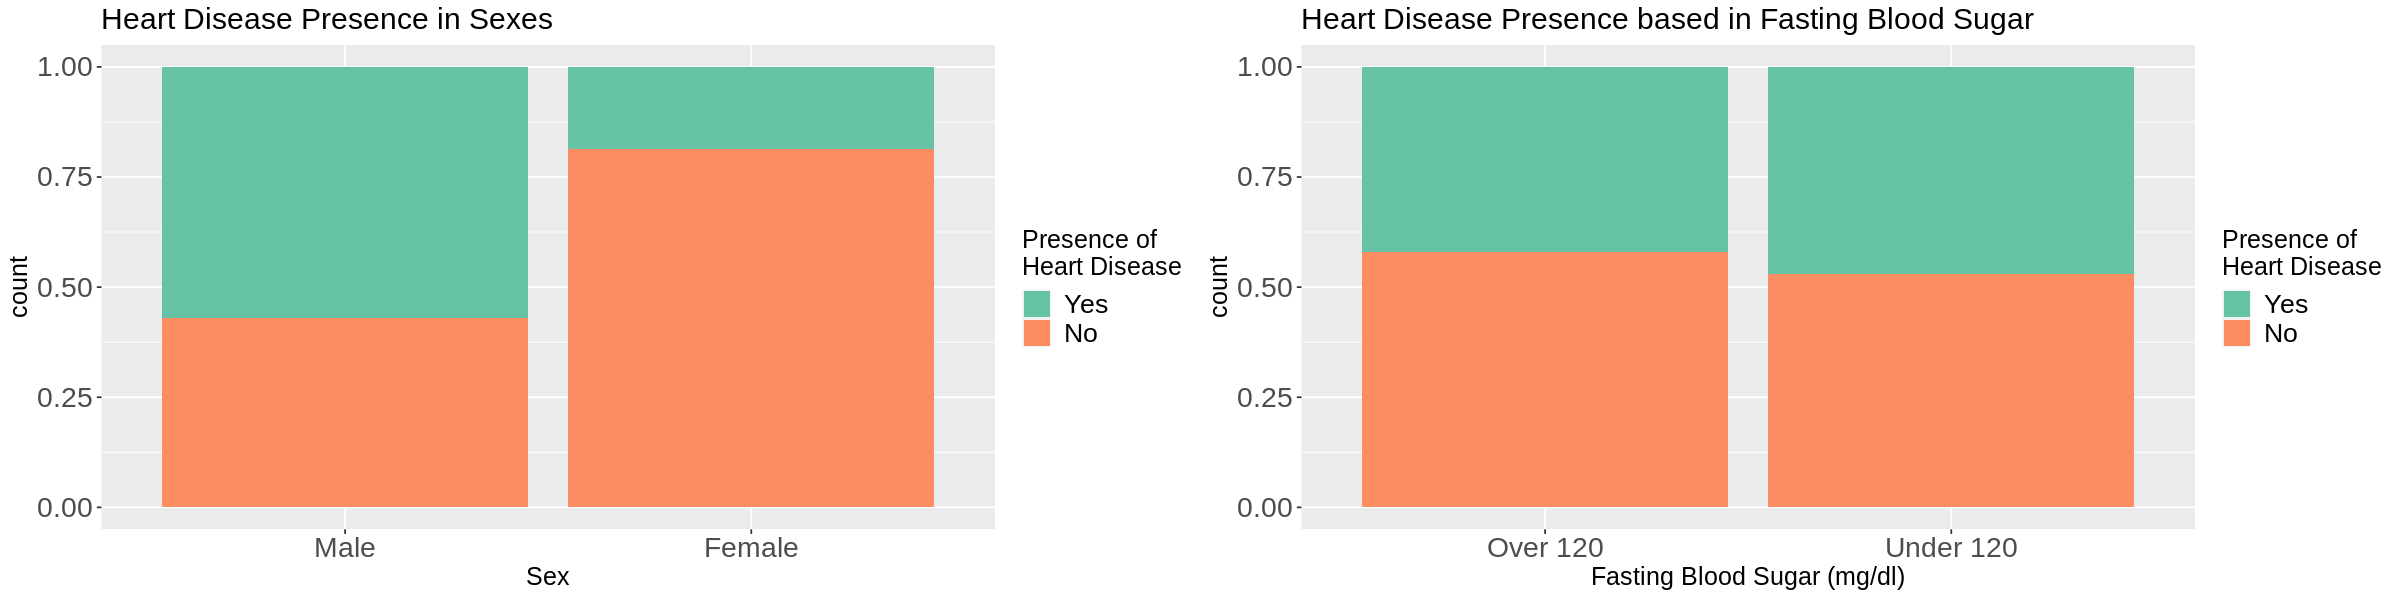

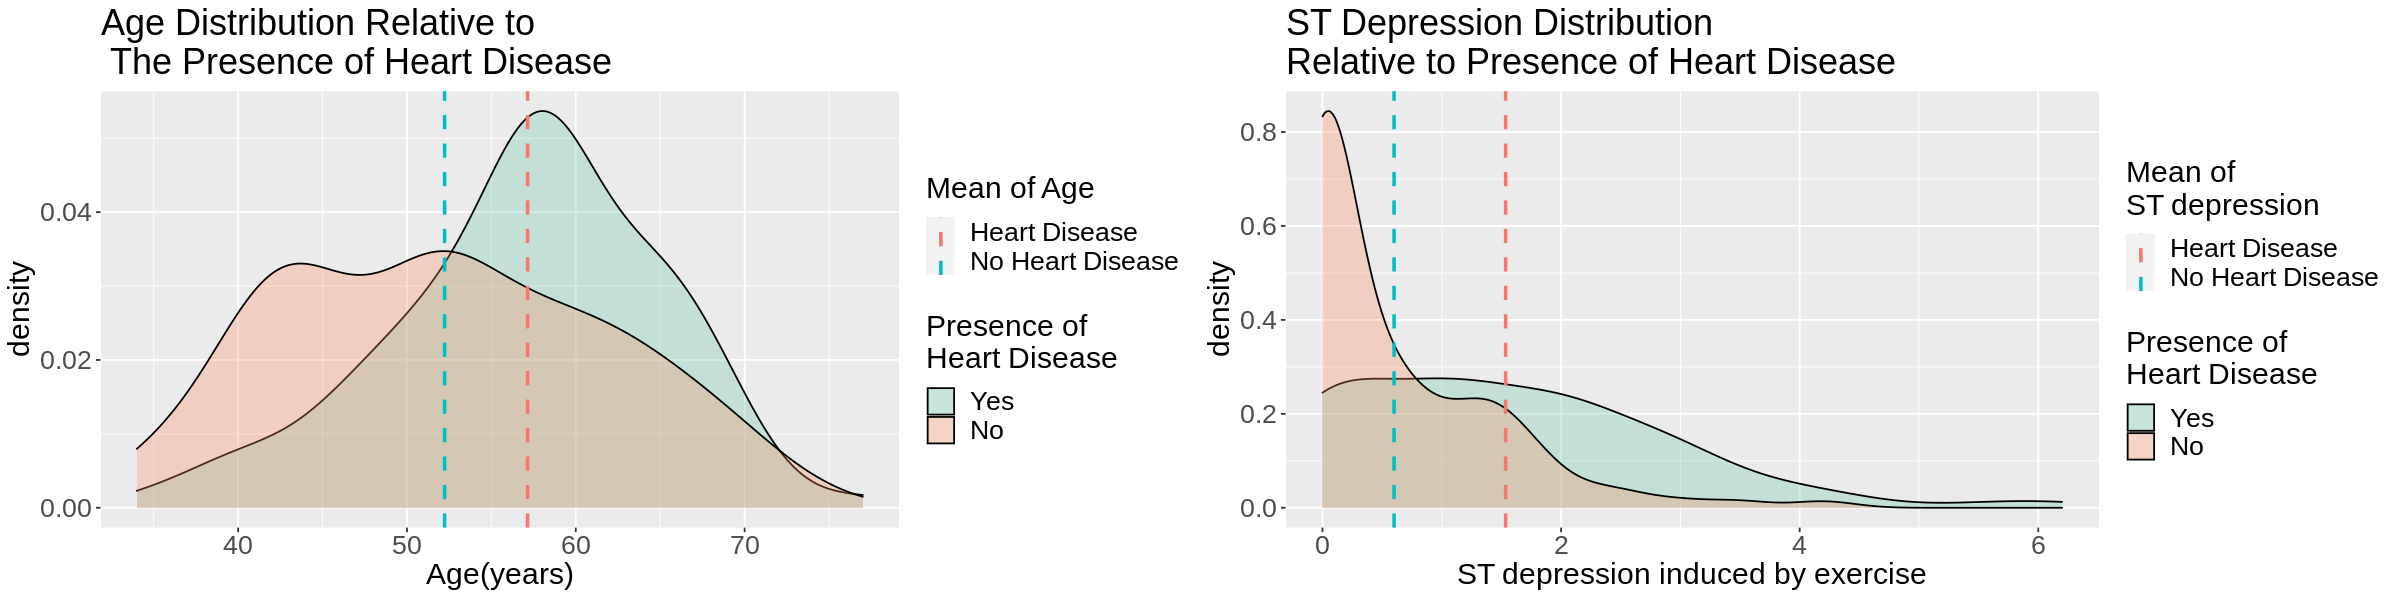

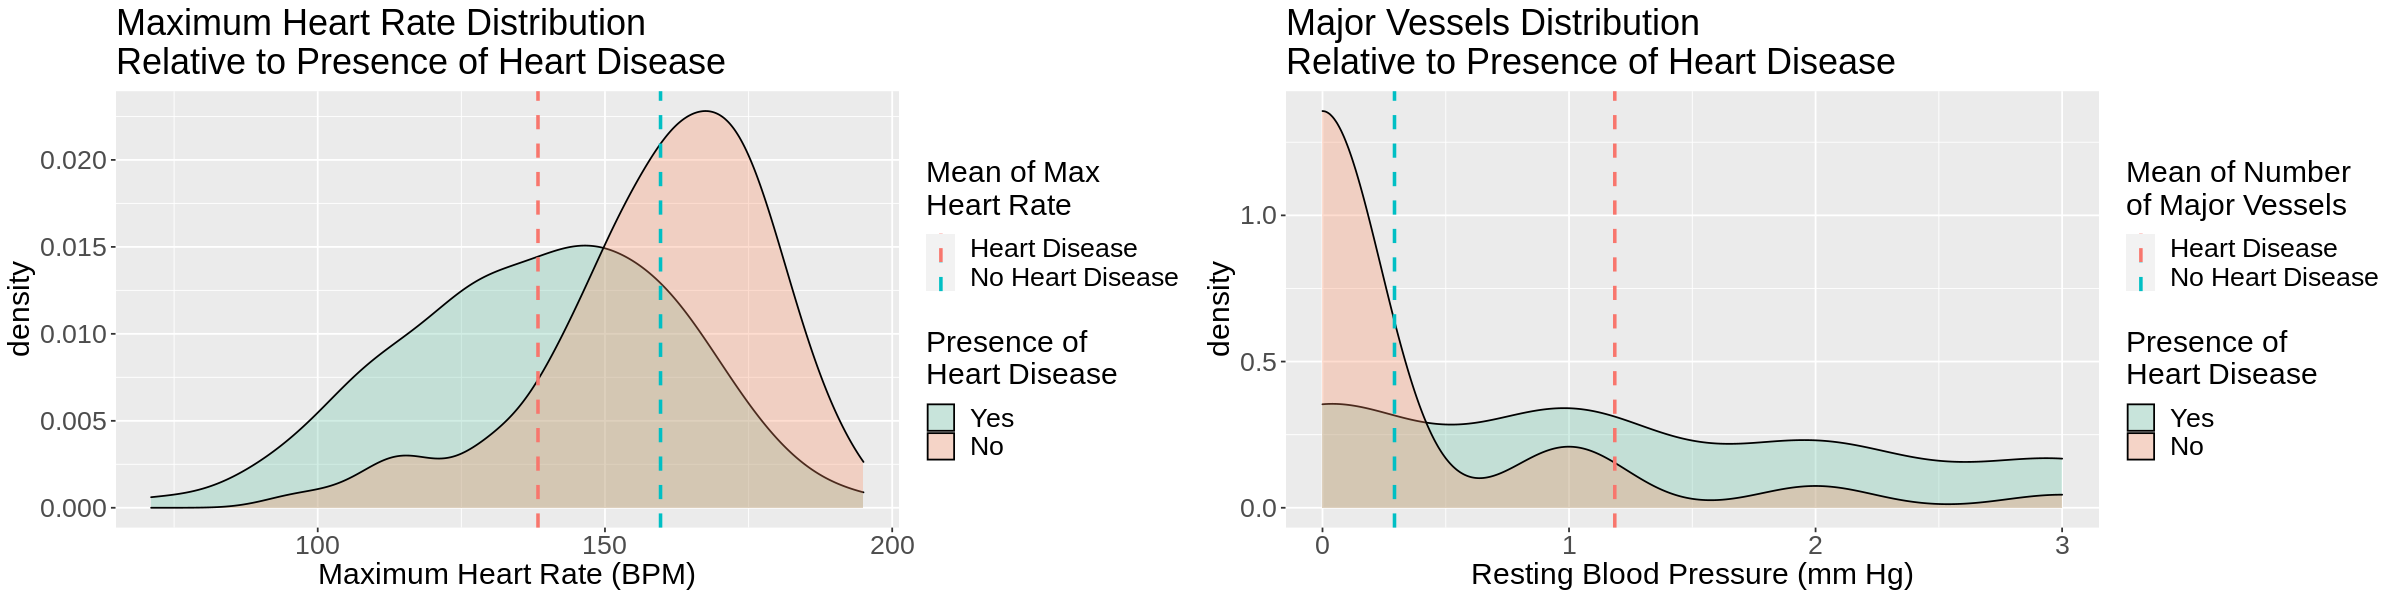

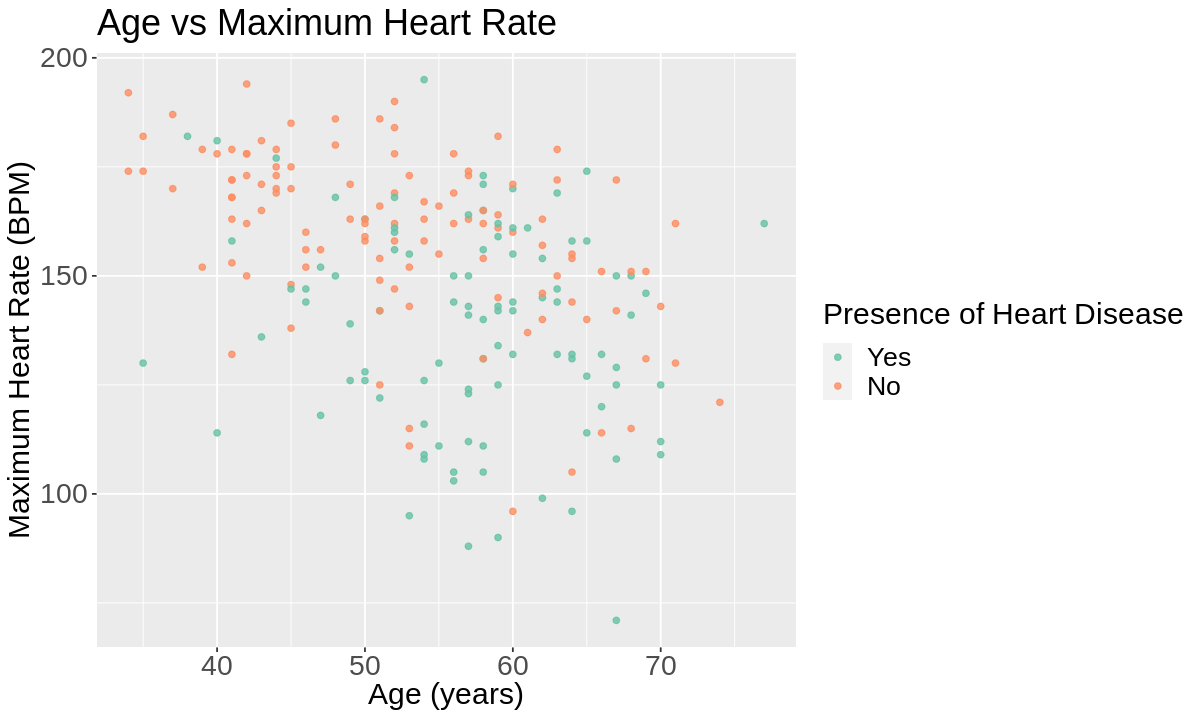

In [8]:
#Visualizing different relevant plots with training data.
options(repr.plot.width = 20, repr.plot.height = 5) 

#Plotting a bar graph looking at presence of heart disease based in the sex.

sex_plot <- ggplot(heart_train, aes(x = sex, fill = diagnosis))             +
             geom_bar(position = "fill")                                    +
             labs(x = "Sex", fill = "Presence of \nHeart Disease")          +
             ggtitle("Heart Disease Presence in Sexes")                     +
             theme(text = element_text(size = 20),
                   axis.text.x = element_text(size = 17),
                   axis.text.y = element_text(size = 17),
                   title       = element_text(size = 15))                   +
             scale_fill_brewer(palette = "Set2")

# Plotting a bar graph looking at presence of heart disease based on fasting 
# blood sugar level.

bs_plot  <- ggplot(heart_train, aes(x = fastingbs, fill = diagnosis))       +
             geom_bar(position = "fill")                                    +
             labs(x = "Fasting Blood Sugar (mg/dl)", 
                  fill = "Presence of \nHeart Disease")                     +
             ggtitle("Heart Disease Presence based in Fasting Blood Sugar") +
             theme(text = element_text(size = 20),
                   axis.text.x = element_text(size = 17),
                   axis.text.y = element_text(size = 17),
                   title       = element_text(size = 15))                   +
             scale_fill_brewer(palette = "Set2")

#Looking at age distribution

age_plot  <- ggplot(heart_train, aes(x = age, fill = diagnosis))            +
              geom_density(alpha = 0.3)                                     +
              geom_vline(data = group_summary, 
                         aes(xintercept = age_mean, color = diagnosis),
                             linetype = "dashed", size = 1)                 +
              labs(x     = "Age(years)", 
                   fill  = "Presence of \nHeart Disease", 
                   color = "Mean of Age")                                   +
              scale_color_hue(labels = c("Heart Disease", 
                                         "No Heart Disease"))               +
    ggtitle("Age Distribution Relative to \n The Presence of Heart Disease")+
              theme(text  = element_text(size = 20),
                    title = element_text(size = 18))                        +
              scale_fill_brewer(palette = "Set2")

#Looking at ST depression induced by exercise distribution

peak_plot <- ggplot(heart_train, aes(x = oldpeak, fill = diagnosis))        +
              geom_density(alpha = 0.3)                                     +
              geom_vline(data = group_summary, 
                         aes(xintercept = oldpeak_mean, 
                             color = diagnosis),
                             linetype="dashed", size=1)                     +
              labs(x     = "ST depression induced by exercise", 
                   fill  = "Presence of \nHeart Disease", 
                   color = "Mean of \nST depression")                       +
              scale_color_hue(labels = c("Heart Disease", 
                                         "No Heart Disease"))               +
ggtitle("ST Depression Distribution \nRelative to Presence of Heart Disease")+
              theme(text  = element_text(size = 20),
                    title = element_text(size = 18))                         +
              scale_fill_brewer(palette = "Set2")

#Looking at maximum heart rate distribution

heartrate_plot <- ggplot(heart_train, 
                         aes(x = maxheartrate, fill = diagnosis))           +
                   geom_density(alpha = 0.3)                                +
                   geom_vline(data    = group_summary, 
                              aes(xintercept = maxheartrate_mean, 
                                  color      = diagnosis),
                                  linetype   = "dashed", 
                                  size       = 1)                           +
                   labs(x     = "Maximum Heart Rate (BPM)", 
                        fill  = "Presence of \nHeart Disease", 
                        color = "Mean of Max \nHeart Rate")                 +
                   scale_color_hue(labels = c("Heart Disease", 
                                              "No Heart Disease"))          +
ggtitle("Maximum Heart Rate Distribution \nRelative to Presence of Heart Disease")+
                   theme(text = element_text(size = 20),
                        title = element_text(size = 18))                    +
                   scale_fill_brewer(palette = "Set2")
      
#Looking at number of major vessels distribution

vessel_plot <- ggplot(heart_train, 
                      aes(x = nmajorvessels, fill = diagnosis))             +
                geom_density(alpha = 0.3)                                   +
                geom_vline(data = group_summary, 
                           aes(xintercept = nmajorvessels_mean, 
                               color      = diagnosis),
                               linetype   = "dashed", 
                               size       = 1)                              +
                labs(x     = "Resting Blood Pressure (mm Hg)", 
                     fill  = "Presence of \nHeart Disease", 
                     color = "Mean of Number \nof Major Vessels")           +
            scale_color_hue(labels = c("Heart Disease", "No Heart Disease"))+
ggtitle("Major Vessels Distribution \nRelative to Presence of Heart Disease")+
                     theme(text  = element_text(size = 20),
                           title = element_text(size = 18))                 +
                scale_fill_brewer(palette = "Set2")
      
plot_grid(sex_plot, bs_plot,           ncol = 2)
plot_grid(age_plot, peak_plot,         ncol = 2)
plot_grid(heartrate_plot, vessel_plot, ncol = 2)

#Plotting a scatter plot with Age vs Maximum Heart Rate
age_heart <- ggplot(heart_train, aes(x = age, y = maxheartrate, 
                                       color = diagnosis))                  +
              geom_point(alpha = 0.8)                                       +
              labs(x = "Age (years)", y = "Maximum Heart Rate (BPM)", 
                   color = "Presence of Heart Disease")                     +
              ggtitle("Age vs Maximum Heart Rate")                          +
              theme(text = element_text(size = 20),
                    axis.text.x = element_text(size = 17),
                    axis.text.y = element_text(size = 17),
                    title       = element_text(size = 18))                  +
              scale_color_brewer(palette = "Set2")

options(repr.plot.width = 10, repr.plot.height = 6)
age_heart



## 3. Methods:  

The chosen predictors are age, sex, number of major vessels colored by fluoroscopy, ST depression induced by exercise, fasting blood sugar, and maximum heart rate. These variables are shown to be heavily correlated to heart diseases based on the graphics above. For example, heart disease presence was shown to triple with each decade of life, which demonstrates the significance of age as a predictor.

For creating the model, the testing set created earlier will be tested to predict the diagnosis based on the variables and see its accuracy. Since it is a small dataset, cross-validation must also be performed. The training set will be divided into 5 folds and the results for neighbors and mean accuracy will be plotted to find the most suitable value of K. Once the value of K has been found, the K-nearest neighbor model will be used to predict the diagnosis of patients in the test set. For visualizing the results, pairs of scatter plots (such as the Age vs Maximum heart rate) will be used to assess the accuracy of the model. The background of each plot will be shaded in the color the model would have classified the points.

## 4. Expected Outcomes & Their Significance 

We would like to derive from this data whether the variables chosen are good predictors in determining the diagnosis of heart disease. Based on the plots above, we expect age, sex, number of major vessels colored by fluoroscopy, ST depression induced by exercise, and maximum heart rate to be able to predict the presence of heart disease. More specifically, older people, with high ST depression, low maximum heart rate, and a high number of major vessels are more prone to be diagnosed positively with heart disease. 

However, the plot for fasting blood sugar shows that people with over 120 mg/dl are more prone to have heart disease, but the difference is quite slight. Despite the grave implications a high blood sugar level might have on the heart, we hypothesize it might not be a good predictor. The impact of such findings could lead to more studies between blood sugar level and heart diseases, thus resulting in questions such as: what kind of heart diseases are most affected by blood sugar level? What is the threshold for blood sugar level and the presence of heart disease?